In [12]:
# 单元格 1 (v2.0)
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from transformers import CLIPProcessor, CLIPModel # <--- 新增导入
import pandas as pd # <--- 确保pandas已导入
from itertools import combinations_with_replacement # <--- 确保itertools已导入

# 设置设备 (MPS for Mac GPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found. Using Apple GPU.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

# 定义数据和输出目录
data_root = '../data'
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)

/Users/jianglikai/SC4020项目/SC4020IBS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jianglikai/SC4020项目/SC4020IBS/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MPS device found. Using Apple GPU.


In [2]:
# [快速重启] 从这里开始，避免重新计算嵌入
import numpy as np
import pandas as pd
import torch
from torchvision import datasets
import os

# --- 新增：导入可视化库 ---
import matplotlib.pyplot as plt
import seaborn as sns
# ------------------------

# 定义数据路径和类别名称
DATA_DIR = '../data'
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 检查并加载特征向量和标签
vectors_path = os.path.join(DATA_DIR, 'fmnist_resnet50_vectors.npy')
labels_path = os.path.join(DATA_DIR, 'fmnist_labels.npy')

if os.path.exists(vectors_path) and os.path.exists(labels_path):
    print("正在加载已保存的特征向量和标签...")
    feature_vectors = np.load(vectors_path)
    labels = np.load(labels_path)
    print("加载完成。")

    # 重新加载原始数据集以供可视化
    print("正在加载原始 FashionMNIST 数据集...")
    full_dataset = datasets.FashionMNIST(
        root=DATA_DIR, 
        train=True, 
        download=True
    )
    print("数据集加载完成。")
else:
    print("错误：未找到已保存的特征向量或标签文件。请从头运行 notebook 以生成它们。")

# 可以在这里添加其他需要恢复的变量

print("\n快速重启环境准备就绪！")

正在加载已保存的特征向量和标签...
加载完成。
正在加载原始 FashionMNIST 数据集...
数据集加载完成。

快速重启环境准备就绪！


In [3]:
# === 快速重启 Cell (v2) ===
# 重启内核后运行这个cell即可恢复所有必要的变量和函数

import torch
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import os
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

# --- 1. 加载已计算的数据 ---
all_vectors = np.load('../data/fmnist_resnet50_vectors.npy')
all_labels = np.load('../data/fmnist_labels.npy')

# --- 2. 重新加载原始数据集 (用于可视化) ---
# 定义预处理流程 (与特征提取时保持一致)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
data_root = '../data'
# 加载数据集 (由于文件已存在，download=True不会重复下载)
train_dataset = FashionMNIST(root=data_root, train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root=data_root, train=False, download=True, transform=transform)
# 合并训练集和测试集
full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# --- 3. 定义必要的函数和变量 ---
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def cosine_similarity(vec_a, vec_b):
    return np.dot(vec_a, vec_b) / (norm(vec_a) * norm(vec_b))

# 设备设置
device = "cuda" if torch.cuda.is_available() else "cpu"

print("✅ 快速重启完成！")
print(f"📊 数据: vectors {all_vectors.shape}, labels {all_labels.shape}")
print(f"🖼️  原始数据集: {len(full_dataset)} 张图片已加载")
print(f"🖥️  设备: {device}")
print("🚀 可以直接运行后续分析代码")

✅ 快速重启完成！
📊 数据: vectors (70000, 2048), labels (70000,)
🖼️  原始数据集: 70000 张图片已加载
🖥️  设备: cpu
🚀 可以直接运行后续分析代码


In [4]:
# 定义预处理流程 (灰度转3通道RGB是关键)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # 使用ImageNet的均值和标准差进行归一化
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集 (由于文件已存在，download=True不会重复下载)
train_dataset = FashionMNIST(root=data_root, train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root=data_root, train=False, download=True, transform=transform)

# 合并训练集和测试集
full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
data_loader = DataLoader(full_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Fashion-MNIST loaded successfully. Total images: {len(full_dataset)}")

Fashion-MNIST loaded successfully. Total images: 70000


In [5]:
# 加载预训练的ResNet-50模型
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights).to(device)
model.fc = torch.nn.Identity()  # 移除最后的分类层，得到2048维特征
model.eval()

print("Pre-trained ResNet-50 model loaded and modified for feature extraction.")

Pre-trained ResNet-50 model loaded and modified for feature extraction.


In [6]:
all_vectors = []
all_labels = []

# 使用torch.no_grad()来节约内存和加速计算
with torch.no_grad():
    for images, labels in tqdm(data_loader, desc="Extracting features"):
        images = images.to(device)
        
        # 得到一个批次的特征向量
        batch_vectors = model(images).cpu().numpy()
        
        all_vectors.append(batch_vectors)
        all_labels.append(labels.numpy())

# 将列表合并成一个大的Numpy数组
all_vectors = np.concatenate(all_vectors, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Feature extraction complete.")
print(f"Shape of feature vectors: {all_vectors.shape}")
print(f"Shape of labels: {all_labels.shape}")

Extracting features:   1%|          | 6/547 [00:11<16:11,  1.80s/it]libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1145a6ca0>
Traceback (most recent call last):
  File "/Users/jianglikai/SC4020项目/SC4020IBS/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/Users/jianglikai/SC4020项目/SC4020IBS/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.fra

KeyboardInterrupt: 

In [ ]:
vector_path = os.path.join(output_dir, "fmnist_resnet50_vectors.npy")
label_path = os.path.join(output_dir, "fmnist_labels.npy")

np.save(vector_path, all_vectors)
np.save(label_path, all_labels)

print(f"Vectors saved to: {vector_path}")
print(f"Labels saved to: {label_path}")

Vectors saved to: ../data/fmnist_resnet50_vectors.npy
Labels saved to: ../data/fmnist_labels.npy


In [5]:
from numpy.linalg import norm

def cosine_similarity(vec_a, vec_b):
    return np.dot(vec_a, vec_b) / (norm(vec_a) * norm(vec_b))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


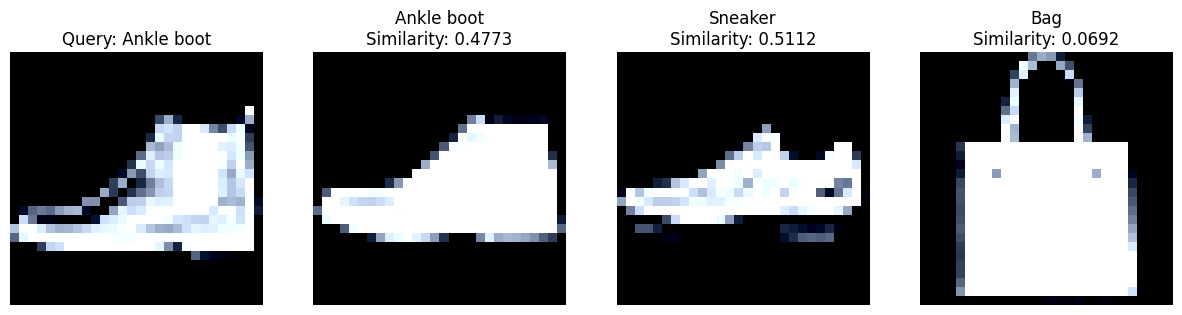

验证完成。请检查同类（Ankle boot）的相似度是否远高于异类。


In [6]:
# --- 验证设置 ---
# 类别1: Ankle boot (脚踝靴), 标签 9
# 类别2: Sneaker (运动鞋), 标签 7
# 类别3: Bag (包), 标签 8
cat1_label, cat2_label, cat3_label = 9, 7, 8
# ------------------

# 找到这些类别的所有样本索引
cat1_indices = np.where(all_labels == cat1_label)[0]
cat2_indices = np.where(all_labels == cat2_label)[0]
cat3_indices = np.where(all_labels == cat3_label)[0]

# 随机选择样本
query_idx = np.random.choice(cat1_indices)
ref_cat1_idx = np.random.choice(np.setdiff1d(cat1_indices, query_idx))
ref_cat2_idx = np.random.choice(cat2_indices)
ref_cat3_idx = np.random.choice(cat3_indices)

indices_to_check = [ref_cat1_idx, ref_cat2_idx, ref_cat3_idx]

# 计算相似度
query_vector = all_vectors[query_idx]
similarities = [cosine_similarity(query_vector, all_vectors[idx]) for idx in indices_to_check]

# --- 可视化 ---
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# 显示查询图像
query_image, _ = full_dataset[query_idx]
axes[0].imshow(query_image.permute(1, 2, 0).numpy() * 0.5 + 0.5) # 反归一化
axes[0].set_title(f"Query: {class_names[cat1_label]}")
axes[0].axis('off')

# 显示对比图像
for i, idx in enumerate(indices_to_check):
    image, label = full_dataset[idx]
    axes[i+1].imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axes[i+1].set_title(f"{class_names[label]}\nSimilarity: {similarities[i]:.4f}")
    axes[i+1].axis('off')

plt.show()

print("验证完成。请检查同类（Ankle boot）的相似度是否远高于异类。")

In [7]:
import pandas as pd
import random

# 我们将对比这三个场景
# 场景1: 同类 (Intra-class) -> Sneaker vs Sneaker
# 场景2: 近义 (Close-class) -> Sneaker vs Ankle boot
# 场景3: 远义 (Distant-class) -> Sneaker vs Bag

# 定义类别标签
sneaker_label = 7
boot_label = 9
bag_label = 8

# 获取各类别的索引
sneaker_indices = np.where(all_labels == sneaker_label)[0]
boot_indices = np.where(all_labels == boot_label)[0]
bag_indices = np.where(all_labels == bag_label)[0]

# 采样数量
num_pairs = 200

# --- 计算同类相似度 ---
intra_class_sims = []
# 确保我们能采样出不重复的对
pairs = random.sample(list(zip(sneaker_indices, np.roll(sneaker_indices, 1))), num_pairs)
for i1, i2 in pairs:
    sim = cosine_similarity(all_vectors[i1], all_vectors[i2])
    intra_class_sims.append(sim)

# --- 计算近义相似度 ---
close_class_sims = []
i1_samples = random.sample(list(sneaker_indices), num_pairs)
i2_samples = random.sample(list(boot_indices), num_pairs)
for i1, i2 in zip(i1_samples, i2_samples):
    sim = cosine_similarity(all_vectors[i1], all_vectors[i2])
    close_class_sims.append(sim)

# --- 计算远义相似度 ---
dist_class_sims = []
i1_samples = random.sample(list(sneaker_indices), num_pairs)
i2_samples = random.sample(list(bag_indices), num_pairs)
for i1, i2 in zip(i1_samples, i2_samples):
    sim = cosine_similarity(all_vectors[i1], all_vectors[i2])
    dist_class_sims.append(sim)

# 将数据整理成DataFrame，方便绘图
df_sim = pd.DataFrame({
    f'{class_names[sneaker_label]} vs {class_names[sneaker_label]}': intra_class_sims,
    f'{class_names[sneaker_label]} vs {class_names[boot_label]}': close_class_sims,
    f'{class_names[sneaker_label]} vs {class_names[bag_label]}': dist_class_sims
})

print("统计数据已生成。")
df_sim.describe() # 显示统计摘要

统计数据已生成。


,Sneaker vs Sneaker,Sneaker vs Ankle boot,Sneaker vs Bag
count,200.000000,200.000000,200.000000
mean,0.385497,0.308018,0.145889
std,0.150491,0.143612,0.092249
min,0.089100,0.059710,0.003259
25%,0.267372,0.191616,0.087034
50%,0.378006,0.293276,0.135305
75%,0.498828,0.406292,0.183886
max,0.778316,0.723377,0.680165


In [ ]:
from sklearn.manifold import TSNE

# 我们将对一个子集进行可视化，以加快速度
num_samples_for_tsne = 5000
random_indices = np.random.choice(len(all_vectors), num_samples_for_tsne, replace=False)

sampled_vectors = all_vectors[random_indices]
sampled_labels = all_labels[random_indices]

print(f"Running t-SNE on {num_samples_for_tsne} samples... This may take a while.")

# 初始化并运行t-SNE
# verbose=1 会显示进度
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate='auto', init='pca')
tsne_results = tsne.fit_transform(sampled_vectors)

print("t-SNE computation complete.")

Running t-SNE on 5000 samples... This may take a while.
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...


/Users/jianglikai/SC4020项目/SC4020IBS/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 13.898517
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.713303
[t-SNE] KL divergence after 1000 iterations: 1.728394
t-SNE computation complete.


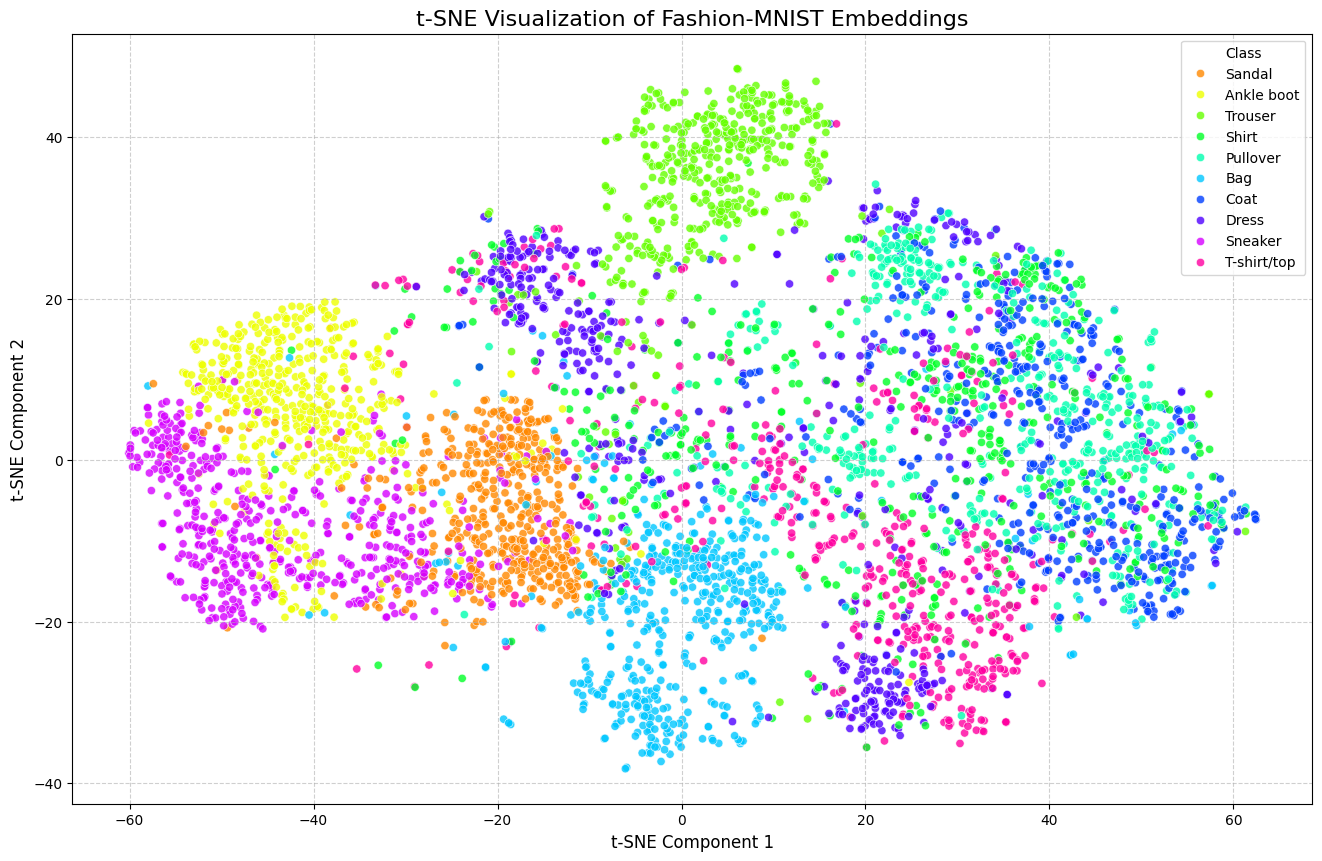

In [ ]:
# 创建一个DataFrame方便用seaborn绘图
df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
df_tsne['label'] = sampled_labels
df_tsne['class'] = df_tsne['label'].apply(lambda x: class_names[x])

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hsv", 10), # 10个类别用10种颜色
    data=df_tsne,
    legend="full",
    alpha=0.8
)

plt.title('t-SNE Visualization of Fashion-MNIST Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Class')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [10]:
# 单元格 14 (修订版)

from itertools import combinations_with_replacement
import pandas as pd # 确保pandas也已导入

# --- (这是新增的部分) ---
# 确保 all_vectors_float32 变量已定义并为正确的类型
# 这行代码会检查 all_vectors 是否存在，如果存在就转换它
if 'all_vectors' in locals() and all_vectors.dtype != 'float32':
    all_vectors_float32 = all_vectors.astype('float32')
elif 'all_vectors_float32' not in locals():
    # 如果两个变量都不存在，就从文件重新加载
    print("重新加载向量数据...")
    all_vectors_float32 = np.load('../data/fmnist_resnet50_vectors.npy')
# --- (新增部分结束) ---


# --- 参数设置 ---
samples_per_class = 100 
# ------------------

# 存储每个类别的平均相似度
similarity_matrix = np.zeros((10, 10))

# 存储每个类别采样的向量
sampled_vectors_by_class = []
for i in range(10):
    indices = np.where(all_labels == i)[0]
    sampled_indices = np.random.choice(indices, samples_per_class, replace=False)
    sampled_vectors_by_class.append(all_vectors_float32[sampled_indices])

# 使用tqdm来显示进度
pbar = tqdm(list(combinations_with_replacement(range(10), 2)), desc="Calculating similarity matrix")

for i, j in pbar:
    # (后续代码保持不变)
    vectors_i = sampled_vectors_by_class[i]
    vectors_j = sampled_vectors_by_class[j]
    
    if i == j:
        centroid_i = np.mean(vectors_i, axis=0)
        sims = [cosine_similarity(vec, centroid_i) for vec in vectors_i]
        avg_sim = np.mean(sims)
    else:
        centroid_i = np.mean(vectors_i, axis=0)
        centroid_j = np.mean(vectors_j, axis=0)
        avg_sim = cosine_similarity(centroid_i, centroid_j)
            
    similarity_matrix[i, j] = avg_sim
    similarity_matrix[j, i] = avg_sim

print("全局相似度矩阵计算完成。")

重新加载向量数据...


Calculating similarity matrix: 100%|██████████| 55/55 [00:00<00:00, 7019.65it/s]

全局相似度矩阵计算完成。


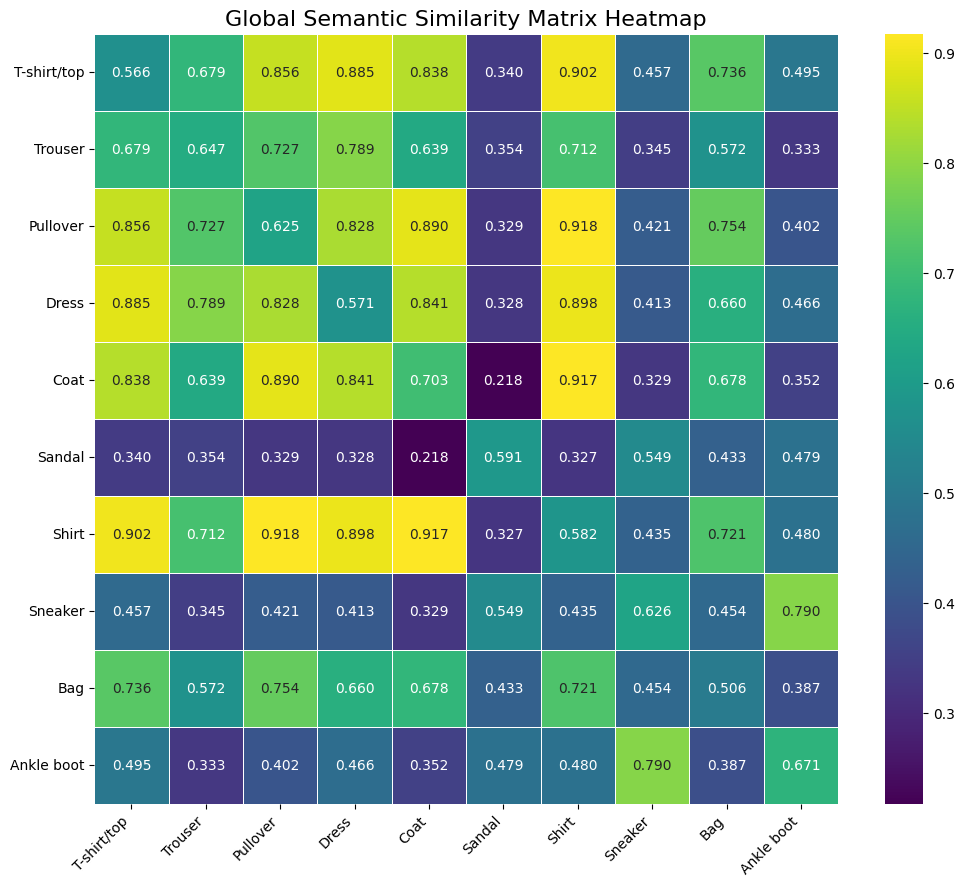

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 将矩阵转换为Pandas DataFrame，并加上类别名称
df_heatmap = pd.DataFrame(similarity_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmap, 
            annot=True,     # 在每个格子里显示数字
            fmt=".3f",      # 数字格式化，保留3位小数
            cmap="viridis", # 选择一个好看的颜色映射
            linewidths=.5)
plt.title('Global Semantic Similarity Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()